In [1]:
import os, json, sys
sys.path.append('../..')

In [2]:
import os.path
import numpy as np
import os
import sklearn.model_selection

In [3]:
import sklearn

import sklearn.model_selection
import sklearn.linear_model
import sklearn.ensemble
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from pprint import pprint

In [4]:
from matplotlib import pyplot as plt
from pprint import pprint

In [5]:
path_ = '/media/tiagobotari/tiagobotari/data/text/rt-polaritydata/rt-polaritydata'
def load_polarity(path=path_):
    data = []
    labels = []
    f_names = ['rt-polarity.neg', 'rt-polarity.pos']
    for (l, f) in enumerate(f_names):
        for line in open(os.path.join(path, f), 'rb'):
            data.append(line.decode('utf8', errors='ignore').strip())
            labels.append(l)
    return data, labels

In [6]:
x, y = load_polarity()
x_train_all, x_test, y_train_all, y_test = train_test_split(
    x, y, test_size=.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, test_size=.1, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [7]:
len(x)

10662

In [8]:
class VectorizeText():
        def __init__(self):
            self.count_vect = CountVectorizer()
            self.tf_transformer = TfidfTransformer(use_idf=False)
        def fit(self, x):
            x = self.count_vect.fit_transform(x)
            self.tf_transformer.fit(x)
        def transform(self, x):
            x = self.count_vect.transform(x)
            x = self.tf_transformer.transform(x)
            return x     

In [9]:
vect_text = VectorizeText()
vect_text.fit(x_train)    
x_vec_train = vect_text.transform(x_train)

# Train Model
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(x_vec_train, y_train)

def MNB_predict(texts):
    return clf.predict(vect_text.transform(texts))
def MNB_predict_prob(texts):
    return clf.predict_proba(vect_text.transform(texts))

preds = MNB_predict(x_val)
print('Val accuracy', sklearn.metrics.accuracy_score(y_val, preds))


Val accuracy 0.7584994138335287


# Explanation

In [10]:
from m_lime.densities.density_word2vec import DensityWord2Vec

In [11]:
density = DensityWord2Vec(x_train_all)
print('Training Error:', density.manifold.loss_training)

Training Error: 2084488.5


In [12]:
from m_lime.explainers.statistics import ExplainStatistics

In [13]:
print('Similarities')
pprint(density.manifold.get_similar_words('the', n_sample=10))

Similarities
[('its', 0.9995957612991333),
 ('a', 0.999464750289917),
 ('his', 0.9994530081748962),
 ('most', 0.9993674755096436),
 ('one', 0.9993656277656555),
 ('lots', 0.9992960095405579),
 ('kind', 0.9992470145225525),
 ('year', 0.9992145895957947),
 ('sense', 0.9991968870162964),
 ('.', 0.9991855025291443),
 (',', 0.9991639852523804),
 ('performances', 0.9991181492805481),
 ('all', 0.9991098642349243),
 ('and', 0.9991033673286438),
 ('an', 0.9990979433059692),
 ('life', 0.9990786910057068),
 ('themes', 0.9990526437759399),
 ('own', 0.9990431070327759),
 ('characters', 0.9990395903587341),
 ('charm', 0.9990203976631165),
 ('execution', 0.9990120530128479),
 ('humor', 0.9989935159683228),
 ('moments', 0.9989866018295288),
 ('lack', 0.9989789724349976),
 ('level', 0.9989596009254456),
 ('sort', 0.998957097530365),
 ('some', 0.998950719833374),
 ('direction', 0.9989433288574219),
 ('full', 0.9989317655563354),
 ('power', 0.9989296197891235),
 ('exploration', 0.9989283084869385),
 ('co

 ('walls', 0.9973388910293579),
 ('event', 0.9973388910293579),
 ("actor's", 0.9973373413085938),
 ('vincent', 0.997336745262146),
 ('wide', 0.9973363280296326),
 ('facing', 0.9973300099372864),
 ('d', 0.9973298907279968),
 ('originality', 0.9973294734954834),
 ('terrorist', 0.9973286986351013),
 ('greater', 0.997328519821167),
 ('frightening', 0.9973278045654297),
 ('better', 0.9973276853561401),
 ('reputation', 0.9973269701004028),
 ('spite', 0.9973267316818237),
 ('attal', 0.9973260164260864),
 ('reach', 0.9973252415657043),
 ('they', 0.9973240494728088),
 ('generate', 0.997323751449585),
 ('crude', 0.9973230957984924),
 ('grown-up', 0.9973229765892029),
 ('die', 0.997322678565979),
 ('showcases', 0.9973224401473999),
 ("they're", 0.9973207712173462),
 ('shadowy', 0.9973198175430298),
 ('junk', 0.9973195791244507),
 ('exquisitely', 0.9973170757293701),
 ('minds', 0.9973161220550537),
 ('lifestyle', 0.9973156452178955),
 ('mysteries', 0.9973155856132507),
 ('rousing', 0.9973139762878

 ('western', 0.9967838525772095),
 ('latin', 0.9967836141586304),
 ('travel', 0.9967827796936035),
 ('rice', 0.9967827200889587),
 ('slack', 0.996782660484314),
 ('bigger', 0.9967826008796692),
 ('tiene', 0.9967823624610901),
 ('manipulation', 0.9967797994613647),
 ('choice', 0.9967796802520752),
 ('dullest', 0.9967774152755737),
 ('castro', 0.9967760443687439),
 ('surely', 0.9967756271362305),
 ('full-bodied', 0.9967753887176514),
 ('burr', 0.9967728853225708),
 ('terrible', 0.9967727661132812),
 ('explosive', 0.9967717528343201),
 ('minute', 0.996770441532135),
 ('impeccable', 0.9967702031135559),
 ('guaranteed', 0.9967699646949768),
 ('meat', 0.9967692494392395),
 ('indulgent', 0.9967687129974365),
 ('tends', 0.9967656135559082),
 ('serving', 0.9967644214630127),
 ('quentin', 0.9967615008354187),
 ('frailty', 0.9967589378356934),
 ('pero', 0.9967546463012695),
 ('understands', 0.9967541098594666),
 ('basically', 0.9967541098594666),
 ('kid', 0.9967538118362427),
 ('tell', 0.99675220

 ("clancy's", 0.9888027310371399),
 ('circles', 0.988801121711731),
 ("thewlis's", 0.9887977838516235),
 ('knockabout', 0.9887974858283997),
 ('hospitals', 0.9887936115264893),
 ('substitutes', 0.9887927770614624),
 ('unconcerned', 0.9887913465499878),
 ('delectable', 0.9887886047363281),
 ('tickets', 0.9887865781784058),
 ('judge', 0.9887818694114685),
 ('tunnels', 0.9887814521789551),
 ('patriotero', 0.9887771010398865),
 ('continuao', 0.9887716770172119),
 ('polite', 0.9887686967849731),
 ('guise', 0.988764762878418),
 ('awfulness', 0.9887642860412598),
 ('downs', 0.9887630343437195),
 ('monster/science', 0.9887621998786926),
 ('department', 0.9887605309486389),
 ('feardotcom', 0.9887603521347046),
 ('averting', 0.9887595176696777),
 ('generations', 0.9887580275535583),
 ('kidnapping', 0.9887575507164001),
 ('reads', 0.9887547492980957),
 ('dating', 0.9887529611587524),
 ('loyal', 0.9887526631355286),
 ('integrated', 0.9887511730194092),
 ('forgoes', 0.9887479543685913),
 ('pelo', 0

 ('megalomaniac', 0.987076461315155),
 ('contrria', 0.9870710372924805),
 ('fantasia', 0.9870614409446716),
 ('recycle', 0.987055778503418),
 ('conflicts', 0.9870554208755493),
 ('insecurity', 0.9870539903640747),
 ('cary', 0.987053632736206),
 ('finn', 0.9870514869689941),
 ('agenda', 0.9870489835739136),
 ('billing', 0.9870429039001465),
 ('inextricably', 0.9870368242263794),
 ('ribisi', 0.9870350360870361),
 ('unpersuasive', 0.9870350360870361),
 ('insignificance', 0.9870302677154541),
 ('roughly', 0.9870262145996094),
 ('couture', 0.9870256781578064),
 ("'swept", 0.9870256185531616),
 ('siblings', 0.9870253205299377),
 ('sun-splashed', 0.9870220422744751),
 ('minimum', 0.987021803855896),
 ('moods', 0.9870197176933289),
 ('caddyshack', 0.9870107173919678),
 ('wiser', 0.9870046973228455),
 ('refuse', 0.9869966506958008),
 ('converted', 0.986995279788971),
 ('randomness', 0.9869886040687561),
 ('ganha', 0.9869863986968994),
 ("'artistically'", 0.9869799613952637),
 ('high-adrenaline'

 ('forrest', 0.9697234630584717),
 ('verite', 0.9697186350822449),
 ('ensuing', 0.9696934223175049),
 ('windshield', 0.9696849584579468),
 ('schoolboy', 0.9696778655052185),
 ('worldly-wise', 0.9696570634841919),
 ('gut-clutching', 0.9696569442749023),
 ('immortal', 0.969653844833374),
 ('narcotized', 0.9696430563926697),
 ('computerized', 0.9696389436721802),
 ('eastern', 0.9696385860443115),
 ('gimmicks', 0.9696349501609802),
 ('shoot-em-ups', 0.9696242809295654),
 ('self-flagellation', 0.9696115255355835),
 ('early-on', 0.969607949256897),
 ("cryin'", 0.9696075320243835),
 ('schtick', 0.9696057438850403),
 ('non-exploitive', 0.9695538878440857),
 ('iben', 0.9695515632629395),
 ('trim', 0.9695502519607544),
 ('dallas', 0.9695417881011963),
 ('pee-related', 0.9695338606834412),
 ('retrieve', 0.9695336818695068),
 ('savviest', 0.9695310592651367),
 ('flavour', 0.9695307016372681),
 ("'triumph'", 0.9695303440093994),
 ('personifying', 0.969528079032898),
 ('step-printing', 0.96949684619

 ('time-switching', 0.9666692018508911),
 ('yarn-spinner', 0.9666659832000732),
 ('transmute', 0.9666600823402405),
 ('firing', 0.966658890247345),
 ('nightclub', 0.9666550159454346),
 ('scooby-doo', 0.9666430950164795),
 ('refers', 0.96663898229599),
 ('downside', 0.9666352868080139),
 ('coarseness', 0.966610848903656),
 ('ramblings', 0.9666078090667725),
 ('endemic', 0.9666063189506531),
 ('unseemly', 0.9666003584861755),
 ('occurrences', 0.966596782207489),
 ('burrito', 0.9665917158126831),
 ('smelly', 0.9665817618370056),
 ('relays', 0.966574490070343),
 ('outta', 0.9665684700012207),
 ('alienated', 0.9665601849555969),
 ("production's", 0.9665472507476807),
 ('banderas-lucy', 0.9665417671203613),
 ('complexly', 0.9665307402610779),
 ('fascinantes', 0.9665282964706421),
 ('78', 0.9665181040763855),
 ('assuredly', 0.9665172696113586),
 ('luminous', 0.9665154814720154),
 ('broder', 0.9665066003799438),
 ('cal', 0.9664912223815918),
 ('factors', 0.9664871096611023),
 ('provokes', 0.96

 ('acumen', 0.9090331196784973),
 ('117', 0.90902179479599),
 ('behalf', 0.9089811444282532),
 ('jaundiced', 0.9089618921279907),
 ('gawky', 0.9089586734771729),
 ('han', 0.9089321494102478),
 ('progenitor', 0.9089180827140808),
 ('inmates', 0.9089141488075256),
 ('edit', 0.9088305234909058),
 ('depleted', 0.9087737798690796),
 ('sarcasm', 0.9087494015693665),
 ('admirers', 0.908699631690979),
 ('obsolete', 0.9086795449256897),
 ('unmentionables', 0.9086766242980957),
 ('crime-film', 0.9086706638336182),
 ('boyz', 0.9086353182792664),
 ('[sex', 0.9086003303527832),
 ('lauded', 0.908561646938324),
 ("'special", 0.9085608720779419),
 ('gates', 0.9085332155227661),
 ("'brazil", 0.9085306525230408),
 ('chuckling', 0.9085285067558289),
 ('intimately', 0.9085185527801514),
 ('debatable', 0.9084776639938354),
 ('yearnings', 0.9083994030952454),
 ("'unfaithful'", 0.9083544611930847),
 ('nba', 0.9083414673805237),
 ('drinker', 0.9082819819450378),
 ('abandoned', 0.9082620739936829),
 ('code-tal

 ('cleanflicks', 0.8967063426971436),
 ('alias', 0.8966982364654541),
 ('waxes', 0.896673321723938),
 ('zoe', 0.8966532945632935),
 ('full-throated', 0.8966496586799622),
 ('combining', 0.8966324925422668),
 ('beaut', 0.8966283798217773),
 ('negated', 0.8966225385665894),
 ('impervious', 0.8965952396392822),
 ('4w', 0.8965771198272705),
 ('synthetic', 0.8965381979942322),
 ('salvation', 0.8965227603912354),
 ('treasures', 0.8963916897773743),
 ('inkling', 0.896338701248169),
 ('valedictory', 0.8962918519973755),
 ("'alabama'", 0.8962172865867615),
 ('patchouli', 0.8962029814720154),
 ('dates', 0.8961623311042786),
 ("pray's", 0.8961506485939026),
 ('hyper-time', 0.8960825204849243),
 ('democracy', 0.8960295915603638),
 ('dissection', 0.8959453105926514),
 ('badder', 0.8959183692932129),
 ('overripe', 0.8959159255027771),
 ('upfront', 0.89588463306427),
 ('50s', 0.8957792520523071),
 ('stones', 0.8957749009132385),
 ('migraine-inducing', 0.8957564830780029),
 ('talked', 0.89574754238128

In [14]:
print('Test:')
x_explain = x_test[1]
print(x_explain)
print('predicted - true')
print(MNB_predict([x_explain]), 1)
print(MNB_predict_prob([x_explain]), 1)

Test:
the movie's thesis -- elegant technology for the masses -- is surprisingly refreshing .
predicted - true
[1] 1
[[0.29029215 0.70970785]] 1


In [15]:
explainer = ExplainStatistics(model_predict=MNB_predict_prob, density=density)

In [16]:
density.generated_data = None
x_explain = [x_explain]
samples = density.sample_radius(x_explain, r=None, n_samples=1000, random_state=None)

In [17]:
x_explain

["the movie's thesis -- elegant technology for the masses -- is surprisingly refreshing ."]

In [43]:
from pprint import pprint
features_names=[f'{e}: {word}' for e, word in enumerate(x_explain[0].split())]

explanation, con_fav_samples = explainer.explain_instance(
    x_explain=x_explain, class_index=1, features_names=features_names, tol=0.001)

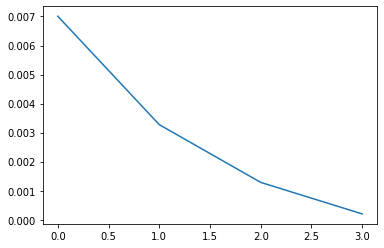

In [44]:
x = range(0, len(explainer.local_model.convergence_diffs))
y = explainer.local_model.convergence_diffs
plt.plot(x[:], y[:])

In [45]:
means = explanation['importance']['mean']

In [46]:
from matplotlib import pyplot as plt

<BarContainer object of 14 artists>

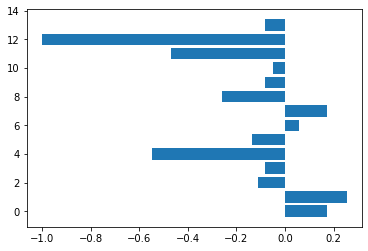

In [47]:
plt.barh([*means.keys()], [*means.values()])

In [23]:
con_fav_samples.samples_fav

["the movie's thesis -- elegant technology for the masses -- is surprisingly too-extreme-for-tv .",
 "the movie's thesis -- elegant technology for the masses -- is surprisingly too-hot-for-tv .",
 "the movie's thesis -- elegant technology for the masses -- is surprisingly ill-conceived .",
 "the movie's thesis -- too-extreme-for-tv technology for the masses -- is surprisingly refreshing .",
 "the movie's thesis -- elegant technology for the masses -- is too-extreme-for-tv refreshing ."]